In [1]:
from dataretrieval import nwis
import geopandas as gpd
from pathlib import Path
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# define your project directory
proj_dir = Path("..")

# Create a directory to store in-situ data
data_dir = proj_dir / "insitu_data"
processed_data_dir = data_dir / "processed"
data_dir.mkdir(exist_ok=True)
processed_data_dir.mkdir(exist_ok=True)

# load metadata
stations_metadata_path = Path(proj_dir, "insitu_data/metadata/stations.csv")
stations_attributes_path = Path(proj_dir, "insitu_data/metadata/dictionaries/stations_attributes.csv")

stations_attributes = pd.read_csv(stations_attributes_path)

if not os.path.exists(stations_metadata_path):
    stations_metadata = pd.DataFrame(columns=stations_attributes['Attribute_name'])
    stations_metadata.to_csv(stations_metadata_path, index=False)

stations_metadata = pd.read_csv(stations_metadata_path)

target_parameters = {
    "00010_Maximum": "max_temp(C)",
    "00010_Minimum": "min_temp(C)",
    "00010_Mean": "avg_temp(C)",
    "00060_Mean": "avg discharge (cfs)",
    "32316_Maximum": "max_f_chla (ug/L)",
    "32316_Minimum": "min_f_chla (ug/L)",
    "32316_Mean": "avg_f_chla (ug/L)",
}

parameter_codes = {
    "max water temperature (C)": "Maximum water temperature, degrees Celsius",
    "min water temperature (C)": "Minimum water temperature, degrees Celsius",
    "avg water temperature (C)": "Mean water temperature, degrees Celsius",
    "avg discharge (cfs)": "Discharge, cubic feet per second",
    "avg discharge (m3/d)": "Discharge, cubic meters per day",
}

startDt = "1982-08-01"
endDt = pd.Timestamp.today().strftime("%Y-%m-%d")

In [3]:
# # Load the basin vector data
# basin_gdf = gpd.read_file(proj_dir / "data/gis/geopackages/columbia_river_basin.gpkg", layer="Basins")

# # divide the bounding box into 16 smaller boxes
# xmin, ymin, xmax, ymax = basin_gdf.bounds.values[0]
# x = np.linspace(xmin, xmax, 5)
# y = np.linspace(ymin, ymax, 5)

# # create a list of lists for the bounding boxes
# bb = []
# for i in range(len(x) - 1):
#     for j in range(len(y) - 1):
#         bb.append(list(np.array([x[i], y[j], x[i + 1], y[j + 1]]).round(6)))

In [4]:
# Load the basin vector data
basin_gdf = gpd.read_file(proj_dir / "geopackages/columbia_river_basin.gpkg", layer="basins")

<Axes: >

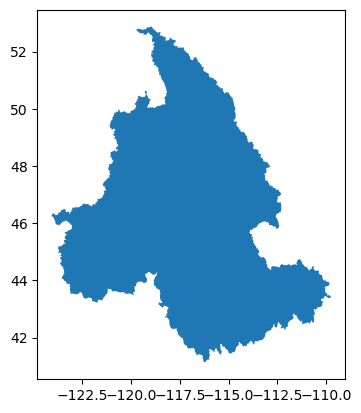

In [5]:
basin_gdf.plot()

In [6]:
# create a list of lists for the bounding boxes
bb = []

for _, region in basin_gdf.iterrows():
    xmin, ymin, xmax, ymax = region['geometry'].bounds
    x = np.linspace(xmin, xmax, 5)
    y = np.linspace(ymin, ymax, 5)
    for i in range(len(x) - 1):
        for j in range(len(y) - 1):
            bb.append(list(np.array([x[i], y[j], x[i + 1], y[j + 1]]).round(6)))

In [7]:
# get the sites for each of the bounding boxes and save them to a dataframe
siteList = []
for i in range(len(bb)):
    try:
        siteList.append(
            nwis.what_sites(
                bBox=bb[i], 
                startDt=startDt, 
                endDt=endDt, 
                parameterCd=[
                    '00010', # USGS Parameter Code for Water Temperature
                ]
            )[0]
        )
    except:
        pass

In [8]:
# remove duplicates
sites_df = pd.concat(siteList).drop_duplicates(subset="site_no").reset_index(drop=True)

<Axes: >

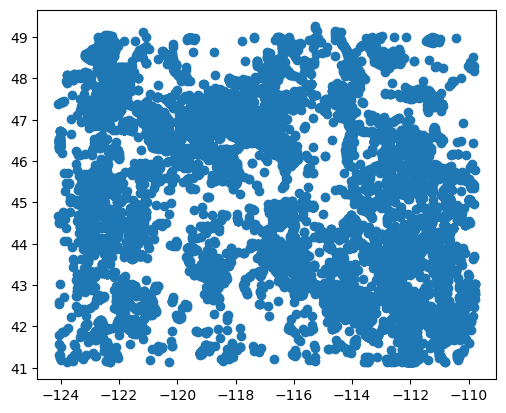

In [9]:
filtered_sites = gpd.GeoDataFrame(sites_df, geometry=gpd.points_from_xy(sites_df['dec_long_va'], sites_df['dec_lat_va']), crs='epsg:4326')
filtered_sites.plot()

<Axes: >

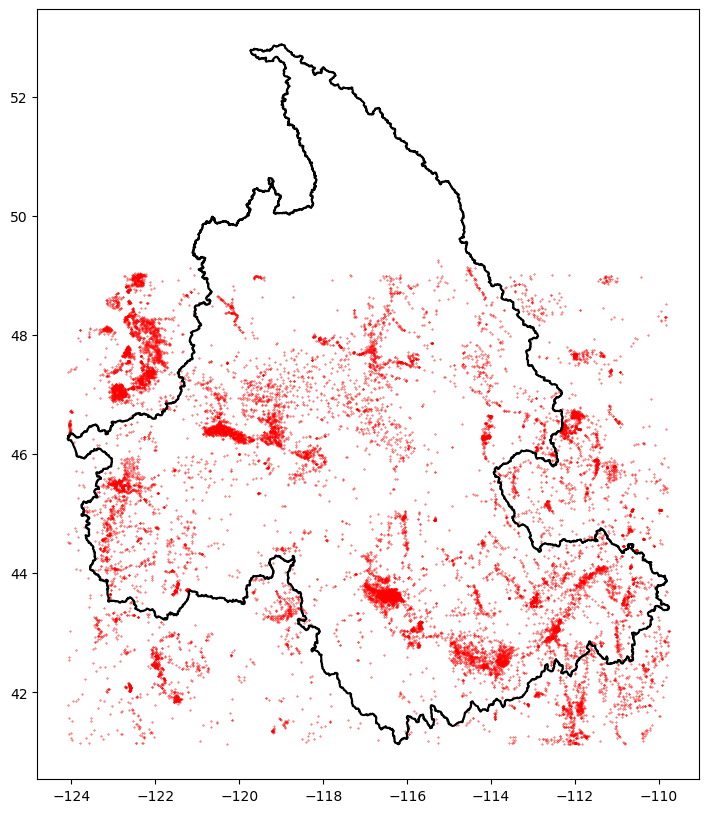

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
basin_gdf.boundary.plot(ax=ax, color='black')
filtered_sites.plot(ax=ax, color='red', markersize=.1)

# Download the data of filtered sites


In [11]:
for site in filtered_sites["site_no"][:10]:
# for site in ['12301933']:
    # for site in ["14070615", "14070620", "14070621"]:
    try:
        site_data = nwis.get_record(sites=site, service="dv", start=startDt, end=endDt)
        site_data.index.rename("date", inplace=True)
        column_dict = {
            col: target_parameters[col]
            for col in site_data.columns
            if col in target_parameters.keys()
        }
        
        site_data.rename(
            columns=column_dict,
            inplace=True,
        )
        if "avg discharge (cfs)" in site_data.columns:
            site_data["outflow(m3/d)"] = (
                site_data["avg discharge (cfs)"] * 0.0283168 * 86400
            )
            column_dict["outflow(m3/d)"] = "outflow(m3/d)"

        if column_dict:
            site_data[column_dict.values()].to_csv(
                Path(processed_data_dir, f"USGS_{site}.csv"), index=True
            )

            # update metadata
            station_ID = "USGS_" + site.upper()

            if station_ID not in stations_metadata["station_ID"].values:
                stations_metadata = pd.concat(
                    [
                        stations_metadata,
                        pd.DataFrame(
                            {
                                "station_ID": [station_ID],
                                "id_at_source": [site.upper()],
                                "available_data": ["{}"],
                                "source_URL": ['{"url" : []}'],
                                "description": [
                                    filtered_sites[
                                        filtered_sites["site_no"] == site
                                    ]["station_nm"].values[0]
                                ],
                                "latitude": [
                                    filtered_sites[
                                        filtered_sites["site_no"] == site
                                    ]["dec_lat_va"].values[0]
                                ],
                                "longitude": [
                                    filtered_sites[
                                        filtered_sites["site_no"] == site
                                    ]["dec_long_va"].values[0]
                                ],
                                "site_params": ["{}"],
                            }
                        ),
                    ],
                    ignore_index=True,
                )

            # update source url
            source_url = json.loads(
                stations_metadata.loc[
                    stations_metadata["station_ID"] == station_ID, "source_URL"
                ].values[0]
            )

            if (
                f"https://waterdata.usgs.gov/monitoring-location/{site}"
                not in source_url["url"]
            ):
                source_url["url"].append(
                    f"https://waterdata.usgs.gov/monitoring-location/{site}"
                )
                stations_metadata.loc[
                    stations_metadata["station_ID"] == station_ID, "source_URL"
                ] = json.dumps(source_url)

            # update the available data
            availble_data = stations_metadata.loc[
                stations_metadata["station_ID"] == station_ID, "available_data"
            ].values[0]
            availble_data = json.loads(availble_data)

            # check if there is "conditions"  in the available data
            if "conditions" not in availble_data.values():
                availble_data["conditions"] = []
            # add the parameters to the available data
            # print(parameters[1:])
            for param in column_dict.values():
                if param not in availble_data["conditions"]:
                    availble_data["conditions"].append(param)

            # update the metadata
            stations_metadata.loc[
                stations_metadata["station_ID"] == station_ID, "available_data"
            ] = json.dumps(availble_data)

            # save the metadata
            stations_metadata.to_csv(stations_metadata_path, index=False)
    except:
        raise

In [12]:
# add last updated date and last updated by
metadata_status = {
    "last_updated": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
    "update_message": "Updated the metadata to for USGS stations",
    "last_updated_by": "George Darkwah",
    "last_updated_by_email": "gdarkwah@uw.edu",
}

# save metadata
with open(Path(data_dir, "metadata/metadata_status.csv"), "w") as f:
    json.dump(metadata_status, f, indent=4)